# TP : Analyse de sentiments dans les critiques de films

### _Pierre Fontaine_ 
#### X 2016 - Master 2 Data Science

## Objectifs

1. Implémenter une manière simple de représenter des données textuelles - Bag of words
2. Implémenter un modèle d'apprentissage statistique basique - Bayésien Naïf
3. Utiliser ces représentations et ce modèle pour une tâche d'analyse de sentiments
4. Implémenter différentes manières d'obtenir des représentations denses des mêmes données
5. Utiliser un modèle de régression logistique pour entraîner un classifieur sur ces nouvelles représentations.

## Dépendances nécessaires

Pour commencer, on aura besoin des packages suivants:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Les deux sont disponibles avec Anaconda: https://anaconda.org/anaconda/nltk et https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt

## Charger les données

On récupère les données textuelles dans la variable *texts*

On récupère les labels dans la variable $y$ qui en contient *len(texts)* : $0$ indique que la critique correspondante est négative tandis que $1$ qu'elle est positive.

In [2]:
from glob import glob
# We get the files from the path: ./data/imdb1/neg for negative reviews, and ./data/imdb1/pos for positive reviews
filenames_neg = sorted(glob(op.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join('.', 'data', 'imdb1', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
texts_neg = [open(f, encoding="utf8").read() for f in filenames_neg]
texts_pos = [open(f, encoding="utf8").read() for f in filenames_pos]
texts = texts_neg + texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

25000 documents


In [3]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
# Attention à bien choisir le paramètre k !

k = 10
texts_reduced = texts[0::k]
y_reduced = y[0::k]

print('Nombre de documents:', len(texts_reduced))

Nombre de documents: 2500


# Bayésien Naïf 

## Idée principale

On dispose d'une critique étant en fait une liste de mots $s = (w_1, ..., w_N)$, et l'on cherche à trouver la classe associée $c$ - qui dans notre cas, peut-être $c = 0$ ou $c = 1$. L'objectif est donc de trouver pour chaque critique $s$ la classe $\hat{c}$ maximisant la probabilité conditionelle **$P(c|s)$** : 

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothèse : P(s) est constante pour chaque classe** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Hypothèse naïve : les différentes variables (mots) d'une critique sont indépendantes entre elles** : 

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$

On va donc pouvoir se servir des critiques annotées à notre disposition pour **estimer les probabilités $P(w|c)$ pour chaque mot $w$ étant donné les deux classes $c$**. Ces critiques vont nous permettre d'apprendre à évaluer la "compatibilité" entre les mots et classes.

## Vue générale

### Entraînement: Estimer les probabilités

Pour chaque mot $w$ du vocabulaire $V$, $P(w|c)$ est le nombre d'occurences de $w$ dans une critique ayant pour classe $c$, divisé par le nombre total d'occurences dans $c$. Si on note $T(w,c)$ ce nombre d'occurences, on obtient:

$$P(w|c) = \text{Fréquence de }w\text{ dans }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

### Test: Calcul des scores

Pour faciliter les calculs et éviter les erreurs d'*underflow* et d'approximation, on utilise le "log-sum trick", et on passe l'équation en log-probabilités : 

$$\hat{c} =  \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\, \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right]$$

### Laplace smoothing (Lissage)

Un mot qui n'apparaît pas dans un document a une probabilité nulle: cela va poser problème avec le logarithme. On garde donc une toute petite partie de la masse de probabilité qu'on redistribue avec le *Laplace smoothing*: 

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$$

Il existe d'autre méthodes de lissage, en général adaptées à d'autres applications plus complexes. 

## Représentation adaptée des documents

Notre modèle statistique, comme la plupart des modèles appliqués aux données textuelles, utilise les comptes d'occurences de mots dans un document. Ainsi, une manière très pratique de représenter un document est d'utiliser un vecteur "Bag-of-Words" (BoW), contenant les comptes de chaque mot (indifférement de leur ordre d'apparition) dans le document. 

Si on considère l'ensemble de tous les mots apparaissant dans nos $T$ documents d'apprentissage, que l'on note $V$ (Vocabulaire), on peut créer **un index**, qui est une bijection associant à chaque mot $w$ un entier, qui sera sa position dans $V$. 

Ainsi, pour un document extrait d'un ensemble de documents contenant $|V|$ mots différents, une représentation BoW sera un vecteur de taille $|V|$, dont la valeur à l'indice d'un mot $w$ sera son nombre d'occurences dans le document. 

On peut utiliser la classe **CountVectorizer** de scikit-learn pour mieux comprendre:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [5]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

On affiche d'abord la liste contenant les mots ordonnés selon leur indice (On note que les mots de 2 caractères ou moins ne sont pas pris en compte).

## Détail: entraînement

L'idée est d'extraire le nombre d'occurences $T(w,c)$ de chaque mot $w$ pour chaque classe $c$, ce qui permettra de calculer la matrice de probabilités conditionelles $\pmb{P}$ telle que: $$\pmb{P}_{w,c} = P(w|c)$$

Notons que le nombre d'occurences $T(w,c)$ peut être obtenu facilement à partir des représentations BoW de l'ensemble des documents.

### Procédure:
<img src="algo_train.png" alt="Drawing" style="width: 700px;"/>

## Détail: test

Nous connaissons maintenant les probabilités conditionelles données par la matrice $\pmb{P}$. 
Il faut maintenant obtenir $P(s|c)$ pour le document courant. Cette quantité s'obtient à l'aide d'un calcul simple impliquant la représentation BoW du document et $\pmb{P}$.

### Procédure:
<img src="algo_test.png" alt="Drawing" style="width: 700px;"/>

## Preprocessing du texte: obtenir les représentations BoW

D'abord, il faut transformer les critiques sous forme de strings en une liste de mots. La tactique la plus simple consiste à diviser le string suivant les espaces, avec la commande:
```text.split()```

Mais il faut aussi faire attention à enlever les caractères particuliers qui pourraient ne pas avoir été nettoyés (comme les balises HTML si on a obtenu les données à partir de pages web). Puisque l'on va compter les mots, il faudra construire une liste des mots apparaissant dans nos données. Dans notre cas, on aimerait réduire cette liste et l'uniformiser (ignorer les majuscules, la ponctuation, et les mots les plus courts). 
On va donc utiliser une fonction adaptée à nos besoins - mais c'est un travail qu'il n'est en général pas nécessaire de faire, puisqu'il existe de nombreux outils déjà adaptés à la plupart des cas de figures. 
Pour le nettoyage du texte, il existe de nombreux scripts, basés sur différents outils (expressions régulières, par exemple) qui permettent de préparer des données. La division du texte en mots et la gestion de la ponctuation est gérée lors d'une étape appellée *tokenization*; si besoin, un package python comme le NLTK contient de nombreux *tokenizers* différents.

In [6]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and statistique2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
#print(clean_and_tokenize(corpus_raw))
#print(word_tokenize(corpus_raw))

Fonction **à compléter**. Elle prend en entrée une liste de document (chacun sous la forme d'un string) et renvoie, comme dans l'exemple utilisant ```CountVectorizer```:
- Un vocabulaire qui associe à chaque mot rencontré un index
- Une matrice, dont les lignes représentent les documents et les colonnes les mots indexés par le vocabulaire. En position $(i,j)$, on devra avoir le nombre d'occurence du mot $j$ dans le document $i$.

Le vocabulaire, qui était sous la forme d'une *liste* dans l'exemple précédent, pourra être renvoyé sous forme de *dictionnaire* dont les clés sont les mots et les valeurs les indices. Puisque le vocabulaire recense les mots du corpus sans se soucier de leur nombre d'occurences, on pourra le constituer à l'aide d'un ensemble (```set``` en python). 
On pourra bien sur utiliser la fonction ```clean_and_tokenize``` pour transformer les strings en liste de mots. 
##### Quelques pointeurs pour les débutants en Python : 

- ```my_list.append(value)``` : put the variable ```value``` at the end of the list ```my_list```

-  ```words = set()``` : create a set, which is a list of unique values 

- ```words.union(my_list)``` : extend the set ```words```

- ```dict(zip(keys, values)))``` : create a dictionnary

- ```for k, text in enumerate(texts)``` : syntax for a loop with the index, ```texts``` begin a list (of texts !)

- ```len(my-list)``` : length of the list ```my_list```


In [7]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    
    ## On parcourt tous les textes du corpus 'texts' et on obtient l'ensemble des mots 'words' en invoquant la
    ## fonction 'clean_and_tokenize'
    
    words = set()
    for text in texts:
        words = words.union(set(clean_and_tokenize(text)))
    
    ## Le dictionnaire 'vocabulary' a pour clefs les mots 'words' et valeurs des indices entiers
    
    n_features = len(words)
    values = set(range(n_features))
    vocabulary = dict(zip(words, values))
    
    counts = np.zeros(shape=(len(texts), n_features), dtype=int)
    # On parcourt les textes du corpus
    for k, text in enumerate(texts):
        # On incrémente la matrice 'counts' pour l'indice du vocabulaire correspondant au mot 'word'
        for word in clean_and_tokenize(text):
            counts[k][vocabulary[word]] += 1
            
    return vocabulary, counts

In [8]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'walk': 0, 'walked': 1, 'the': 2, 'avenue': 3, 'city': 4, 'ran': 5, 'down': 6, 'boulevard': 7}
[[0 1 1 0 0 0 2 1]
 [0 1 1 1 0 0 1 0]
 [0 0 1 0 0 1 1 1]
 [1 0 1 0 1 0 1 0]
 [1 0 2 1 0 0 1 0]]


## Bayésien Naïf 

Classe vide : fonctions **à compléter** : 

```python
def fit(self, X, y)
``` 
**Entraînement** : va apprendre un modèle statistique basés sur les représentations $X$ correspondant aux labels $y$.
$X$ représente donc ici des représentations obtenues en sortie de count_words. On complète la fonction à l'aide de la procédure détaillée plus haut. Si il est possible de la suivre à la lettre, les représentations que l'on utilise nous permettre d'être bien plus efficace et d'éviter d'utiliser des boucles !


Note: le lissage, effectué à la ligne $10$, ne se fait pas nécessairement avec un $1$, mais peut se faire avec une valeur positive $\alpha$, qu'on peut implémenter comme argument de la classe ```NB```.

```python
def predict(self, X)
```
**Testing** : va renvoyer les labels prédits par le modèle pour d'autres représentations $X$.


Pour faciliter la procédure, on prendra la moitié de la matrice $X$ obtenue plus haut pour entraîner le modèle, et l'autre moitié pour l'évaluer. **Important**: cette façon de procéder n'est pas réaliste: en général, on ne dispose que des données d'entraînement au moment de créer le vocabulaire et d'entraîner le modèle. Ainsi, il est possible que les données d'évaluation contiennent des mots *inconnus*. C'est quelque chose qu'on peut traiter facilement en dédiant un indice à tous les mots rencontrés qui ne sont pas contenus dans le vocabulaire - mais il existe de nombreuses méthodes plus complexes pour réussir à utiliser à bon escient ces mots que le modèle n'a pas rencontré à l'entraînement. 

##### Quelques pointeurs pour les débutants en Python : 

Utiliser l'API Numpy pour travailler avec des tenseurs


- ```X.shape``` : for a ```numpy.array```, return the dimension of the tensor

- ```np.zeros((dim_1, dim_2,...))``` : create a tensor filled with zeros

- ```np.sum(X, axis = n)``` : sum the tensor over the axis n

- ```np.mean(X, axis = n)```

- ```np.argmax(X, axis = n)```

- ```np.log(X)```

- ```np.dot(X_1, X_1)``` : Matrix multiplication

In [9]:
class NB(BaseEstimator, ClassifierMixin):
    # Les arguments de classe permettent l'héritage de classes de sklearn
    def __init__(self, alpha=1.0):
        # alpha est un paramètre pour le lissage: il correspond à la valeur ligne 10 de l'algorithme d'entraînement
        # Dans l'algorithme d'entraînement, et comme valeur par défaut, on utilise alpha = 1
        self.alpha = alpha     
        
    ## On applique l'algorithme TRAINMULTINOMIALNB pour deux classes '0' et '1', ce qui correspond finalement à
    ## TRAINBINOMIALNB
    
    ## Remarque : on a choisi de considérer directement les logarithmes des priors et des probabilités
    ## conditionnelles dans la fonction 'fit'
    
    def fit(self, X, y):
        # Taille du vocabulaire
        v = X.shape[1]
        # Taille du corpus
        n = X.shape[0]
        # Logarithmes des probabilités conditionnelles
        self.log_cond_prob = np.zeros((v, 2))
        # Logarithmes des priors pour les deux classes
        self.log_prior = [0, 0]
        # Prior de classe c = card(X de classe c) / card(X)
        self.log_prior[0], self.log_prior[1] = np.log(len(X[y==0])/n), np.log(len(X[y==1])/n)
        # Compteur des tokens selon le vocabulaire, pour chaque classe
        compt = np.zeros((v, 2))
        # On parcourt le vocabualire
        for it in range(v):
            # Initialisation à alpha
            compt[it][0], compt[it][1] = self.alpha, self.alpha
            # On parcourt la classe '0'
            for x_0 in X[y==0]:
                compt[it][0] += x_0[it]
            # On parcourt la classe '1'
            for x_1 in X[y==1]:
                compt[it][1] += x_1[it]
        # On somme les compteurs dans 'acc'
        acc = np.sum(compt, axis=0)
        acc_0, acc_1 = acc[0], acc[1]
        # On calcule les probabilités conditionnelles selon la formule de l'algorithme
        for it in range(v):
            self.log_cond_prob[it][0] = np.log(compt[it][0] / acc_0)
            self.log_cond_prob[it][1] = np.log(compt[it][1] / acc_1)
        return self
        
    
    def predict(self, X):
        result = []
        # On parcourt X
        for x in X:
            # On extrait les mots du texte 'x'
            words = []
            for it, xx in enumerate(x):
                if xx!=0:
                    words += xx*[it]
            score = np.zeros((2))
            # On incrémente les scores pour les deux classes : '0' et '1'
            score[0], score[1] = self.log_prior[0], self.log_prior[1]
            for word in words:
                score[0] += self.log_cond_prob[word][0]
                score[1] += self.log_cond_prob[word][1]
            # Le résultat privilégié est celui maximisant le score
            result.append(np.argmax(score))
        return result
                    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## Expérimentation

On utilise la moitié des données pour l'entraînement, l'autre pour tester le modèle.

In [10]:
voc, X = count_words(texts_reduced)

In [11]:
nb = NB()
nb.fit(X[::2], y_reduced[::2])
print(nb.score(X[1::2], y_reduced[1::2]))

0.796


## Cross-validation 

Avec la fonction *cross_val_score* de scikit-learn

In [12]:
scores = cross_val_score(nb, X, y_reduced, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

Score de classification: 0.7804 (std 0.022249494376277386)


## Evaluer les performances: 

**Quelles sont les points forts et les points faibles de ce système ? Comment y remédier ?**

Nous obtenons les résultats suivants pour notre implmentation du Classifieur Bayésien Naïf en fonction de `k` :

|`k`| Score| Score de validation croisée|
|:-:|:----:|:--------------------------:|
| 10| 0.796|           0.7804 (std 0.02)|
| 25| 0.778|            0.767 (std 0.02)|

Nous verrons au cours de ce TP s'il est possible d'en obtenir de meilleurs. Ils semblent déjà prometteurs car la méthode de classification bayésienne est relativement simple (naïve).

#### *Points forts :* 
* Le Classifieur Bayésien Naïf a une bonne capacité de classifciation car il repose sur une théorie mathématique efficace quoique naïve. En outre, les résultats obtenus par le classifieur s'expliquent simplement en terme de probabilités.
* Il est facile à implémenter et considéré d'éxécution rapide.
* On peut facilement l'élargir à une classification multicatégorielle (plus de deux classes) si l'on souhaite considérer une autre classification que la classification binaire.
* Il est relativement insensible aux données absurdes ou erronées, il est donc robuste.


#### *Point faible :*
* Le Classifieur Bayésien Naïf suppose l'indépendance des données : si différents textes sont corrélés, les résultats de la théorie mathématique ne sont plus valides. Cette condition est presque toujours violée dans les cas rééls.
* Il est très sensible à la forme des données d'entrée.

#### *Solution pour y remédier :*

* Même si les données ne sont pas indépendantes, on observe des résultats satisfaisants en pratique. On peut cependant songer à des classifieurs plus complexes, qui prennent en compte les cas de dépendance. Leur implémentation est cependant plus difficile.

## Pour aller plus loin: 

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

## Scikit-learn

### Améliorer les représentations

On utilise la function 
```python
CountVectorizer
``` 
de scikit-learn pour constituer notre corpus. Elle nous permettra d'améliorer facilement nos représentations BoW.

#### Tf-idf:

Il s'agit du produit de la fréquence du terme (TF) et de sa fréquence inverse dans les documents (IDF).
Cette méthode est habituellement utilisée pour extraire l'importance d'un terme $i$ dans un document $j$ relativement au reste du corpus, à partir d'une matrice d'occurences $mots \times documents$. Ainsi, pour une matrice $\mathbf{T}$ de $|V|$ termes et $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

On peut l'adapter à notre cas en considérant que le contexte du deuxième mot est le document. Cependant, TF-IDF est généralement plus adaptée aux matrices peu denses, puisque cette mesure pénalisera les termes qui apparaissent dans une grande partie des documents. 
    
#### Ne pas prendre en compte les mots trop fréquents:

On peut utiliser l'option 
```python
max_df=1.0
```
pour modifier la quantité de mots pris en compte. 

#### Essayer différentes granularités:

Plutôt que de simplement compter les mots, on peut compter les séquences de mots - de taille limitée, bien sur. 
On appelle une séquence de $n$ mots un $n$-gram: essayons d'utiliser les 2 et 3-grams (bi- et trigrams).
On peut aussi tenter d'utiliser les séquences de caractères à la place de séquences de mots.

On s'intéressera aux options 
```python
analyzer='word'
```
et 
```python
ngram_range=(1, 2)
```
que l'on changera pour modifier la granularité. 

In [14]:
## On peut définir une pipeline que l'on modifiera pour expérimenter.

## Base

pipeline_base = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_base, texts_reduced, y_reduced, cv=5)
print("Classification score: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## TF-IDF

pipeline_tf_idf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_tf_idf, texts_reduced, y_reduced, cv=5)
print("Classification score tf-idf: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Max DF (choisir une fraction entre 0 et 1 afin de conserver la proportion de mots)

pipeline_maxdf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None, max_df=0.25)),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_maxdf, texts_reduced, y_reduced, cv=5)
print("Classification score sans mots fréquents: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Bigram Words

pipeline_bigram = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None, ngram_range=(1, 2))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_bigram, texts_reduced, y_reduced, cv=5)
print("Classification score bigram: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Trigram Words

pipeline_trigram = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None, ngram_range=(1, 3))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_trigram, texts_reduced, y_reduced, cv=5)
print("Classification score trigram: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Trigram Words TF-IDF

pipeline_trigram_tfidf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None, ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_trigram_tfidf, texts_reduced, y_reduced, cv=5)
print("Classification score trigram TF-IDF: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Quadrigram Words

pipeline_quadrigram = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None, ngram_range=(1, 4))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_quadrigram, texts_reduced, y_reduced, cv=5)
print("Classification score quadrigram: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Pentagram Words

pipeline_pentagram = Pipeline([
    ('vect', CountVectorizer(analyzer='word', stop_words=None, ngram_range=(1, 6))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_pentagram, texts_reduced, y_reduced, cv=5)
print("Classification score pentagram: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Bigram Char

pipeline_char = Pipeline([
    ('vect', CountVectorizer(analyzer='char', stop_words=None, ngram_range=(1, 2))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_char, texts_reduced, y_reduced, cv=5)
print("Classification score char and bigram: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Trigram Char

pipeline_char_trigram = Pipeline([
    ('vect', CountVectorizer(analyzer='char', stop_words=None, ngram_range=(1, 3))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_char_trigram, texts_reduced, y_reduced, cv=5)
print("Classification score char and trigram: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

## Quadrigram Char

pipeline_char_quadri = Pipeline([
    ('vect', CountVectorizer(analyzer='char', stop_words=None, ngram_range=(1, 4))),
    ('clf', MultinomialNB()),
])
scores = cross_val_score(pipeline_char_quadri, texts_reduced, y_reduced, cv=5)
print("Classification score char and quadrigram: %s (std %s)" % (round(np.mean(scores), 3), round(np.std(scores), 3)))

Classification score: 0.781 (std 0.021)
Classification score tf-idf: 0.783 (std 0.024)
Classification score sans mots fréquents: 0.785 (std 0.019)
Classification score bigram: 0.805 (std 0.017)
Classification score trigram: 0.816 (std 0.016)
Classification score trigram TF-IDF: 0.812 (std 0.022)
Classification score quadrigram: 0.816 (std 0.019)
Classification score pentagram: 0.815 (std 0.02)
Classification score char and bigram: 0.682 (std 0.03)
Classification score char and trigram: 0.722 (std 0.033)
Classification score char and quadrigram: 0.751 (std 0.027)


Les résultats obtenus avec les différentes _pipelines_ sont, pour `k=10` :

|   Pipeline|Score de validation croisée|
|:--------:|:-------------------------:|
|   Basique| 0.781 (std 0.021)|
|TF-IDF| 0.783 (std 0.024) |
|Sans mots fréquents| 0.785 (std 0.019)|
|Bigram|0.805 (std 0.017)|
|Trigram|0.816 (std 0.016)|
|Trigram & TF-IDF|0.812 (std 0.022)|
|Quadrigram|0.816 (std 0.019)|
|Pentagram|0.815 (std 0.02)|
|Char & Bigram|0.682 (std 0.03)|
|Char & Trigram| 0.722 (std 0.033)|
|Char & Quadrigram| 0.751 (std 0.027)|



- On remarque que les classifications sur des mots avec des $n$-_grams_ ont de bons résultats, mais plus $n$ est grand, plus le calcul est coûteux (le temps de calcul reste cependant acceptable dans notre cas). Le _trigram_ est le cas préférable.

- L'utilisation du transformeur TF-IDF donne un résultat légérement moins performant que celui de la classification basique, ou bien même si on compose aussi avec une approche $n$-_gram_.

- Les  résultats sur les séquences de caractères sont moins performants, ce qui semble cohérent puisque l'analyse sur les mots semble davantage cohérente

### Natural Language Toolkit (NLTK)

### Stemming 

Permet de revenir à la racine d'un mot: on peut ainsi grouper différents mots autour de la même racine, ce qui facilite la généralisation. Utiliser:
```python
from nltk import SnowballStemmer
```

In [15]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

#### Exemple d'utilisation:

In [16]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print("word :", word, "; stemmed :", stemmer.stem(word))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


#### Transformation des données:

Classe vide : function **à compléter** 
```python
def stem(X)
``` 

In [17]:
def stem(X): 
    
    ## On parcourt les textes de 'X' et on applique la fonction 'stemmer.stem' à chaque mot du texte 'text' auquel
    ## on a auparavant appliqué la fonction 'clean_and_tokenize'
    
    X_stem = []
    for text in X:
        text_stem = ""
        for word in clean_and_tokenize(text):
            # On sépare les mots par un espace, on ajoute le mot de 'stem(word)' au texte 'text_stem'
            text_stem += " " + stemmer.stem(word) 
        X_stem.append(text_stem)
    return X_stem

In [18]:
texts_stemmed = stem(texts_reduced)
voc, X = count_words(texts_stemmed)
nb = NB()

scores = cross_val_score(nb, X, y_reduced, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

Score de classification: 0.7708 (std 0.016473008225579216)


On constate une baisse du score : celui-ci est de $0.771$ alors qu'on avait précédemment un score de $0.780$ avec `nb`.

### Partie du discours

Pour généraliser, on peut aussi utiliser les parties du discours (Part of Speech, POS) des mots, ce qui nous permettra  de filtrer l'information qui n'est potentiellement pas utile au modèle. On va récupérer les POS des mots à l'aide des fonctions:
```python
from nltk import pos_tag, word_tokenize
```

In [19]:
import nltk
from nltk import pos_tag, word_tokenize

#### Exemple d'utilisation:

In [20]:
#import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#print(pos_tag(word_tokenize(('I am Sam'))))

Détails des significations des tags POS: https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

####  Transformation des données:

Classe vide : fonction **à compléter** 
```python
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB'])
``` 

Ne garder que les noms, adverbes, verbes et adjectifs pour notre modèle. 

In [21]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    X_pos = []
    
    ## On parcourt les éléments de 'X', on retient uniquement les éléments dont le 'ptag' est 
    ## dans la liste 'good_tags'
    
    for text in X:
        text_pos = ""
        for ptag in pos_tag(word_tokenize(text)):
            # Test d'appartenance
            if ptag[1] in good_tags:
                # On sépare les mots par un espace, on ajoute le mot de 'ptag' au texte 'text_pos'
                text_pos += " " + ptag[0]
        X_pos.append(text_pos)
        
    return X_pos

In [22]:
texts_POS = pos_tag_filter(texts_reduced)
voc, X = count_words(texts_POS)
nb = NB()

scores = cross_val_score(nb, X, y_reduced, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

Score de classification: 0.7464000000000001 (std 0.014164744967700631)


On constate une baisse du score : celui-ci est de $0.746$ alors qu'on avait précédemment un score de $0.780$ et de $0.771$ pour le texte après _stemmatization_.

## Résumé des résultats avec le Classifieur Bayésien Naïf

#### Résultats obtenus pour `k=10` (corpus de $2500$ textes)

|Méthode |Score de validation croisée|
|:------:|:-------------------------:|
| Basique|          0.7804 (std 0.02)|
|  TF-IDF|          0.783 (std 0.024)|                
| Bi-gram|          0.805 (std 0.017)|
|Tri-gram|          0.816 (std 0.016)|
| Stemmed|         0.7708 (std 0.016)|
| POS-tag|         0.7464 (std 0.014)|


#### Résultats obtenus pour `k=25` (corpus de $1000$ textes)

|Méthode |Score de validation croisée|
|:------:|:-------------------------:|
| Basique|           0.767 (std 0.02)|
|  TF-IDF|           0.749 (std 0.03)|
| Bi-gram|           0.797 (std 0.02)|
|Tri-gram|           0.801 (std 0.02)|
| Stemmed|           0.759 (std 0.02)|
| POS-tag|           0.713 (std 0.01)|     

### Discussion sur ces résultats

- Le _stemming_ et le _POS-tag filtering_ donnent des résultats moins performants que la méthode basique en terme de scores.
- Les méthodes utilisant le _bi-gram_ ou le _tri-gram_ sont les plus prometteuses.

## Utilisation d'un classifieur plus complexe ?

On peut utiliser les implémentations scikit-learn de classifieurs moins naïfs, comme la régression logistique ou les SVM. Quel en est l'inconvénient principal (imaginons que, plutôt qu'un modèle linéaire, on choisisse d'utiliser un réseau de neurones à plusieurs couches cachées ?)

In [23]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [24]:
pipeline_logistic = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(solver='lbfgs', max_iter = 10000)),
])

pipeline_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LinearSVC(max_iter = 10000)),
])

scores = cross_val_score(pipeline_logistic, texts_reduced, y_reduced, cv=5)
print("Classification score Régression Logistique: %s (std %s)" % (np.mean(scores), np.std(scores)))

scores = cross_val_score(pipeline_svc, texts_reduced, y_reduced, cv=5)
print("Classification score SVM: %s (std %s)" % (np.mean(scores), np.std(scores)))

Classification score Régression Logistique: 0.8084 (std 0.007310266752998798)
Classification score SVM: 0.7988000000000001 (std 0.008352245207128448)


Les résultats obtenus (`k=10`) sont :

| Classifieur | Score de validation croisée |
|:--------------:|:---------:|
|Régression Logistique| 0.8084 (std 0.007)|
|SVM| 0.7988 (std 0.008)|


* Les résultats obtenus sont du même ordre voire inférieurs à ceux que nous avions ci-dessus avec le Classifieur Bayésien Naïf, et l'utilisation d'une granularité de $3$. Ils n'offrent donc pas d'amélioration notable.

* Pour un jeu de données trop grand, on a un risque d'_overfitting_ pour non seulement la Régression Logistique, mais aussi les SVM.

* Nous pouvons également regretter l'absence de modèle probabilistique compréhensible comme c'était le cas avec le Classifieur Bayésien Naïf.

* Bien que ce soit le plus simple, le Classifieur Bayésien Naïf doit être préféré dans notre cas aux classifieurs plus complexes.

# Représentations denses

##  Word Embeddings : Représentations distribuées via l'hypothèse distributionelle

**But**: On va chercher à obtenir des représentations denses (comme vecteurs de nombres réels) de mots (et éventuellement de phrases). Ces représentations ont vocation à être distribuées: ce sont des représentations non-locales. On représente un objet comme une combinaison de *features*, par opposition à l'attribution d'un symbole dédié: voir le travail fondateur d'entre autres, Geoffrey Hinton, sur le sujet: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

Le terme de représentation *distribuées* est très général, mais correspond à que l'on cherche à obtenir. L'enjeu est donc de pouvoir construire, automatiquement, de telles représentations.

**Idée sous-jacente**: Elle est basée sur l'hypothèse distributionelle: les informations contextuelles suffisent à obtenir une représentation viable d'objets linguistiques.
 - *“For a large class of cases [...] the  meaning  of a word is  its  use in the  language.”* Wittgenstein (Philosophical Investigations, 43 - 1953)
 - *“You shall know a word by the company it keeps”*, Firth ("A synopsis of linguistic theory 1930-1955." - 1957)

Ainsi, on peut caractériser un mot par les mots qui l'accompagnent, via des comptes de co-occurences. Deux mots ayant un sens similaire auront une distribution contextuelle similaire et auront donc plus de chance d'apparaître dans des contextes similaires. Cette hypothèse peut servir de justification à l'application de statistiques à la sémantique (extraction d'information, analyse sémantique). Elle permet aussi une certaine forme de généralisation: on peut supposer que les informations que l'on a à propos d'un mot se généraliseront aux mots à la distribution similaire. 

**Motivation**: On cherche à obtenir des représentations distribuées pour pouvoir, de manière **efficace**:
- Directement réaliser une analyse sémantique de surface.
- S'en servir comme source d'informations pour d'autres modèles et applications liées au language, notamment pour l'analyse de sentiments. 


**Terminologie**: Attention à ne pas confondre l'idée de représentation *distribuée* et *distributionelle*. Le second indique en général (pour les mots) que la représentation a été obtenue strictement à partir de comptes de co-occurences, alors qu'on pourra utiliser des informations supplémentaires (labels de documents, tags de partie du discours, ...) pour construire des représentations distribuées. 
Les modèles qui permettent de construire ces représentations denses, sous forme de vecteurs, sont souvent appellés *vector spaces models*. On appelle aussi régulièrement ces représentations des *word embeddings*, car les mots sont embarqués (*embedded*) dans un espace vectoriel. En Français, on rencontre souvent le terme *plongements de mots* ou *plongements lexicaux*.

## Obtenir une représentation: comptes d'occurences et de co-occurences

Selon le type de corpus dont on dispose, on pourra obtenir différents types d'informations distributionelles. Si l'on a accès à une collection de documents, on pourra ainsi choisir de compter le nombre d'occurence de chaque mot dans chacun des documents, pour obtenir une matrice $mots \times documents$: c'est sur ce principe qu'est construit **Tf-Idf**. On va maintenant s'intéresser à un cas plus général: on dispose d'une grande quantité de données sous forme de texte, et on cherche à obtenir des représentations de mots sous forme de vecteurs de taille réduite, sans avoir besoin d'un découpage en documents ou catégories. 

Supposons qu'on dispose d'un corpus contenant $T$ mots différents. On va construire une matrice $\mathbf{M}$ de taille $T \times T$ qui contiendra le nombre de co-occurences entre les mots. Il y aura différents facteurs à considérer lors de la construction de cette matrice: 
- Comment définir le 'contexte' d'un mot, qui permettra de dire que les termes qu'il contient co-occurent avec ce mot ? On pourra choisir d'utiliser différentes échelles: le document, la phrase, le groupe nominal, ou tout simplement une fenêtre de $k$ mots, selon les informations que l'on cherche à capturer.
*Encore une fois, si par exemple notre corpus est divisé en $D$ documents, on pourra même s'intéresser aux liens distributionnels entre mots et documents: chacun de ces $D$ documents agira comme un "contexte", et on construit une matrice d'occurences $\mathbf{M}$ de dimension $T \times D$, où $\mathbf{M}_{t,d}$ contient le nombre d'occurences du mot $t$ dans le document $d$.* 
- Comment quantifier l'importance des comptes ? Par exemple, on pourra donner un poids décroissant à une co-occurence selon la distance entre les deux mots concernés ($\frac{1}{d+1}$ pour une séparation par $d$ mots).
- Faut-il garder tous les mots qui apparaissent dans le corpus ? En général, non. On verra que pour les grands corpus, le nombre de mots différents $T$ est énorme. Deuxièmement, même si le nombre de mots est raisonnable, on ne possèdera que très peu d'information distributionelle sur les mots les plus rares, et la représentation obtenue sera à priori de mauvaise qualité. Il faudra se poser la question de comment filtrer ces mots, et de comment traiter les mots qu'on choisit de ne pas représenter.  

#### Procédure

Pour construire la matrice, on va dans un premier temps recueillir la liste des mots différents (ou le *vocabulaire* $V$) qui apparaissent dans le corpus sous forme de dictionaire {mots -> index}
Puis, pour chaque terme $w$ du corpus,
- On récupère l'index $i$ correspondant à l'aide de $V$
- Pour chaque terme $w'$ du contexte de $w$, 
  + On récupère l'index $j$ correspondant à l'aide de $V$
  + On incrémente $\mathbf{M}_{i,j}$ par le poids correspondant, ou par $1$. 
  
La procédure est très proche de celle qu'on a suivi au TP précédent, excepté qu'il faut maintenant compter les mots suivant leur apparition 
  
#### Exemple

On considère le corpus suivant: 

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

On choisit de définir le contexte d'un mot comme la phrase à laquelle il appartient, et de ne pas utiliser de poids. 
On obtient la matrice suivante: 

|               | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

### Obtenir un Vocabulaire:

Cette fois, on va implémenter séparément une fonction retournant le vocabulaire. Il faudra ici pouvoir contrôler sa taille, que ce soit en indiquant un nombre maximum de mots, ou un nombre minimum d'occurences pour qu'on prenne en compte les mots. On ajoute, à la fin, un mot "inconnu" qui remplacera tous les mots qui n'apparaissent pas dans notre vocabulaire 'limité'. 

In [9]:
from nltk.tokenize import word_tokenize

def vocabulary(corpus, count_threshold=1, voc_threshold=0):
    """    
    Function using word counts to build a vocabulary
    Params:
        corpus (list of list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary - 0 (default) indicates there is no max
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency 
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: word counts in the corpus
    """
    
    # On parcourt tous les textes du corpus 'corpus' et tous les mots de chaque texte 'text'..
    # Pour chaque mot, on distingue le cas où il est déjà présent ou non dans le dictionnaire.
    
    word_counts = {}
    for text in corpus:
        # On pourrait utiliser `word_tokenize`
        for word in clean_and_tokenize(text):
            # 'word' est déjà présent dans 'word_counts'
            if word in word_counts:
                word_counts[word] += 1
            # 'word' n'est pas encore présent dans 'word_counts'
            else:
                word_counts[word] = 1
    
    # On ne conserve que les mots dont l'occurence est supérieure à 'count_threshold'
    filtered_word_counts = {w : word_counts[w] for w in word_counts if word_counts[w] >= count_threshold} 
   

    vocabulary_word_counts = dict()
    # Si 'voc_threshold est nul', on conserve tous les mots, il suffit de trier 'filtered_word_counts'
    if voc_threshold == 0:
        for k, v in sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse = True):
            vocabulary_word_counts[k] = v
        # S'il n'existe pas, on crée 'UNK'
        if 'UNK' not in vocabulary_word_counts:
            vocabulary_word_counts['UNK'] = 0
            
    else:
        # Sinon, on crée 'tmp', qui correspond à 'filtered_word_counts' ordonné
        tmp = {}
        for k, v in sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse = True):
            tmp[k] = v
        
        # On va incrémenter négativement 'voc_thr'
        voc_thr = voc_threshold-1
        # On parcourt le dictionnaire ordonné 'tmp'
        for word in tmp:
            # Si on est encore dans la limite du vocabulaire
            if voc_thr > 0:
                voc_thr -= 1
                # On ajoute le mot 'word' comme clef et son occurence comme valeur au dictionnaire
                vocabulary_word_counts[word] = tmp[word]
            # Sinon ce sera le mot inconnu 'UNK'
            else:
                # S'il existe déjà on augmente l'occurence des mots inconnus
                if 'UNK' in vocabulary_word_counts:
                    vocabulary_word_counts['UNK'] += tmp[word]
                # Sinon on crée l'entrée 'UNK'
                else:
                    vocabulary_word_counts['UNK'] = tmp[word]
        # S'il n'existe pas, on crée 'UNK'
        if 'UNK' not in vocabulary_word_counts:
            vocabulary_word_counts['UNK'] = 0
    
    # On parcourt le dictionnaire 'vocabulary_word_counts' qui est trié par construction afin de construire le
    # dictionnaire 'vocabulary' en incrémentant une variable 'index' qui correspond à un rang selon la fréquence
    
    vocabulary = {}
    index = 0
    for elt in vocabulary_word_counts:
        vocabulary[elt] = index
        index += 1
        
    return vocabulary, vocabulary_word_counts

In [10]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'UNK': 2}
{'down': 6, 'the': 6, 'UNK': 0}
{'down': 0, 'the': 1, 'walked': 2, 'boulevard': 3, 'avenue': 4, 'walk': 5, 'ran': 6, 'city': 7, 'UNK': 8}
{'down': 6, 'the': 6, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


- Ici, on ne retrouve pas exactement ce qui est suggéré : cependant, on peut vérifier qu'en remplaçant `clean_and_tokenize` par `nltk.tokenize.word_tokenize` dans la fonction `vocabulary`, on obtient exactement le résultat suivant :

```css
{'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'i': 5, 'UNK': 0}
{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}
```

- On préférera cependant l'implémentation de  `vocabulary` avec `clean_and_tokenize` pour la suite du TP.

### Obtenir les co-occurences:

La fonction prend en entrée le corpus (une liste de strings, correspondant aux documents, ou phrases) et un vocabulaire, ainsi que la taille de la fenêtre de contexte. On pourra aussi implémenter la solution la plus simple - que le contexte d'un mot soit le reste du document duquel il provient. 
Enfin, on pourra implémenter la possibilité de faire décroitre linéairement l'importance d'un mot du contexte à mesure qu'on s'éloigne du mot d'origine. 

In [11]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    np.seterr(divide='ignore', invalid='ignore')
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Obtenir la phrase:
        sent = word_tokenize(sent)
        # Obtenir les indexs de la phrase grace au vocabulaire: 
        sent_idx = []
        ind_unk = len(vocabulary)-1
        for w in sent:
            if w in vocabulary:
                sent_idx.append(vocabulary[w])
            else:
                sent_idx.append(ind_unk)
        # Parcourir les indexs de la phrase et ajouter 1 / dist(i,j) à M[i,j] si les mots d'index i et j apparaissent dans la même fenêtre. 
        for i, idx_i in enumerate(sent_idx):
            # On vérifie que le mot est reconnu par le vocabulaire:
            if idx_i > -1:
                # Si on considère un contexte limité:
                if window > 0:
                    # On crée une liste qui contient les indexs de la fenêtre à gauche de l'index courant 'idx_i'
                    l_ctx_idx = [sent_idx[jj] for jj in range(max(i-window, 0),i)]
                # Si on considère que le contexte est la phrase entière:
                else:
                    # La liste qui contient le contexte à gauche du mot est plus facile à créer:
                    l_ctx_idx = [sent_idx[jj] for jj in range(len(sent_idx)) if jj != i]
                # On parcourt cette liste et on update M[i,j]:    
                for j, idx_j in enumerate(l_ctx_idx):
                    # ... en s'assurant que le mot correspondant à 'idx_j' est reconnu par le vocabulaire
                    if idx_j > -1:
                        # Calcul du poids:
                        if distance_weighting:
                            # Le poids est l'inverse de la distance entre i et j, le facteur 1/2 est chosi car
                            # les poids sont affectés deux fois par construction
                            # Le poids est de l'ordre de 1 / (d+1) où d est la distance entre 'i' et 'j'
                            weight = .5 / (np.abs(i - j) + 1)
                        else:
                            weight = 0.5
                        M[idx_i, idx_j] += weight * 1.0
                        M[idx_j, idx_i] += weight * 1.0
    return M  

In [12]:
print(co_occurence_matrix(corpus, voc, 0, False))
# Attention: les résultats sont différents de l'exemple plus haut car le vocabulaire n'est pas exactement le même: vérifiez par vous même.

[[2. 7. 3. 3. 2. 2. 1. 1. 6.]
 [7. 2. 2. 2. 3. 3. 1. 1. 6.]
 [3. 2. 0. 1. 1. 0. 0. 0. 2.]
 [3. 2. 1. 0. 0. 0. 1. 0. 2.]
 [2. 3. 1. 0. 0. 1. 0. 0. 2.]
 [2. 3. 0. 0. 1. 0. 0. 1. 2.]
 [1. 1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0. 1.]
 [6. 6. 2. 2. 2. 2. 1. 1. 0.]]


#### Application à un vrai jeu de données

On va chercher à obtenir ces comptes pour les données **imdb**.

#### Etude rapide des données

On voudrait ici, avant de procéder, avoir une idée de ce que contiennent ces critiques de films. On va donc obtenir le vocabulaire (entier) et représenter les fréquences des mots, dans l'ordre (attention, il faudra utiliser une échelle logarithmique): on devrait retrouver la loi de Zipf. Cela nous permettra d'avoir une idée de la taille du vocabulaire qu'on pourra choisir : il s'agit de réaliser un compromis entre les ressources nécessaires (taille des objets en mémoire) et quantité d'informations qu'on peut en tirer (les mots rares peuvent apporter beaucoup d'informations, mais il est difficile d'en apprendre de bonnes représentations,car ils sont rares !)  

In [13]:
corpus = texts

vocab, word_counts = vocabulary(corpus)
rank_counts = {w:[vocab[w], word_counts[w]] for w in vocab}
rank_counts_array = np.array(list(rank_counts.values()))

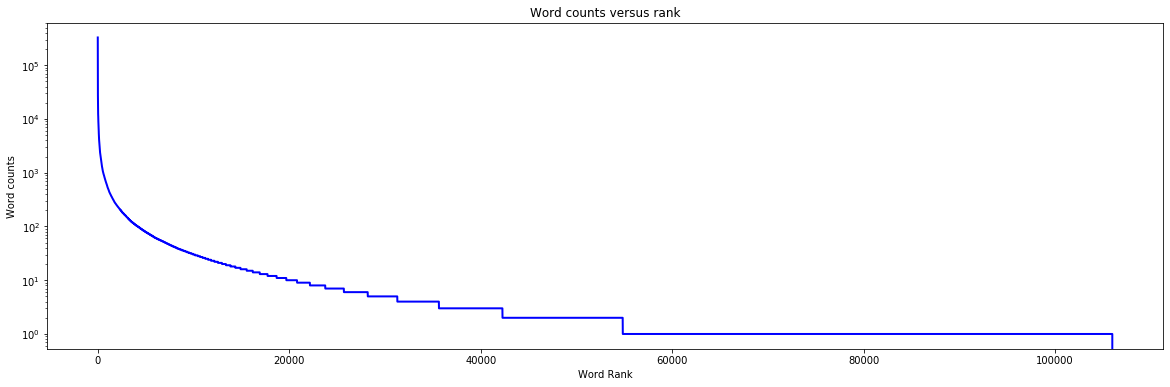

In [14]:
plt.figure(figsize=(20,6))
plt.title('Word counts versus rank')
# plt.scatter(rank_counts_array[:,0], rank_counts_array[:,1], marker="+")
plt.plot(rank_counts_array[:,0], rank_counts_array[:,1], linewidth=2, color = 'blue')
plt.yscale('log')
plt.xlabel('Word Rank')
plt.ylabel('Word counts')
plt.show()

- On retrouve bien la représentation de la loi de Zipf : la fréquence d'un mot est approximativement inversement proportionnelle à son rang. La représentation à angles rectangulaires pour les mots de rangs élevés est liée à l'échelle logarihmique qui impose cette représentation peu esthétique.

In [15]:
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(5000, len(vocab), 10000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))

Vocabulary size: 105978
Part of the corpus by taking the "x" most frequent words:
5000 : 0.87
15000 : 0.95
25000 : 0.97
35000 : 0.98
45000 : 0.98
55000 : 0.99
65000 : 0.99
75000 : 0.99
85000 : 1.00
95000 : 1.00
105000 : 1.00


Résultat de l'analyse: on peut se contenter d'un vocabulaire de 10000, voire 5000 mots - c'est important, car cela va déterminer la taille des objets que l'on va manipuler. On va maintenant recréer la matrice de co-occurence avec différents paramètres. Cela peut-être long: si cela pose problème, travaillez avec un vocabulaire plus réduit.

In [16]:
vocab_5k, word_counts_5k = vocabulary(corpus, 0, 5000)
M5dist = co_occurence_matrix(corpus, vocab_5k, window=5, distance_weighting=True)
M20 = co_occurence_matrix(corpus, vocab_5k, window=20, distance_weighting=False)
print(M5dist.shape)
print(M20.shape)

(5000, 5000)
(5000, 5000)


In [17]:
print(vocab_5k['cinema'])
print(M5dist[411])
print(M20[411])

411
[ 9.60200929  2.65424656  1.91615234 ...  0.          0.
 79.77124659]
[ 1035.5   521.5   251.5 ...     0.      0.  11185.5]


### Comparaison de vecteurs

On peut se servir de ces vecteurs de très grande taille pour une analyse sémantique très basique: par exemple, en cherchant les plus proches voisins d'un mot. Cependant, il faudra faire attention aux distances qu'on utilise, liées à certaines métriques (Euclidiennes, Cosine) ou éventuellement d'autres liées à l'appartenance aux ensembles (Matching, Jaccard). La normalisation des vecteurs peut aussi jouer un rôle. Dans tous les cas, il faut bien faire attention à ne pas sur-interprêter ce type de résultats. 

In [18]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):  
    np.seterr(divide='ignore', invalid='ignore')
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])
    
print("Avec un contexte large, sans prendre en compte la distance entre les mots:")    
print_neighbors(euclidean, vocab_5k, M20, 'good')
print_neighbors(cosine, vocab_5k, M20, 'good')
print("")
print("Avec un contexte plus petit, et en réduisant l'impact des paires de mots selon leur distance:")    
print_neighbors(euclidean, vocab_5k, M5dist, 'good')
print_neighbors(cosine, vocab_5k, M5dist, 'good') 

Avec un contexte large, sans prendre en compte la distance entre les mots:
Plus proches voisins de good selon la distance 'euclidean': 
[['some', 'more', 'very', 'would', 'what', 'there', 'which', 'can', 'out']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'decent', 'really', 'just', 'still', 'very', 'not', 'nice', 'lot']]

Avec un contexte plus petit, et en réduisant l'impact des paires de mots selon leur distance:
Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'really', 'out', 'just', 'had', 'who', 'first', 'story', 'what']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'bad', 'funny', 'interesting', 'very', 'decent', 'well', 'the', 'little']]


**Normalisation**: Très simple; il s'agit d'annuler l'influence de la magnitude des comptes sur la représentation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: Il s'agit d'évaluer à quel point la co-occurence des deux termes est *inattendue*. En effet, cette mesure correspond au ratio de la probabilité jointe des deux mots et du produit de leur probabilités individuelles:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
La probabilité jointe des deux mots correspond au nombre de fois ou on les observe ensemble, divisé par le nombre total de co-occurences du corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
La probabilité individuelle d'un mot correspond simplement à sa fréquence, que l'on peut calculer en comptant toutes les co-occurences ou ce mot apparaît:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Ainsi,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
On calcule ainsi le décalage entre l'observation que l'on a fait dans notre corpus et la fréquence d'apparition de ces termes si on les considère indépendant - c'est à dire qu'on suppose que leur co-occurence est une coïncidence.

Le principal problème avec cette mesure est qu'elle n'est pas adaptée au cas où l'on observe aucune co-occurence. Puisque la PMI est censée renvoyer une quantité positive si l'on observe plus de co-occurences que prévu, et négative si l'on en observe moins, on ne peut pas choisir de remplacer $\log(0)$ par $0$. Une solution couramment utilisée est d'utiliser la **Positive PMI**, qui fixe toutes les valeurs négatives à $0$.
 
 $$\text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases}$$

In [19]:
def pmi(co_oc, positive=True):
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))                   
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    pmi[np.isnan(pmi)] = 0.0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi

In [20]:
PPMI5 = pmi(M5dist)
PPMI20 = pmi(M20)

print("Avec la PPMI5:")    
print_neighbors(euclidean, vocab_5k, PPMI5, 'good')
print_neighbors(cosine, vocab_5k, PPMI5, 'good')
print("Avec la PPMI20:")   
print_neighbors(euclidean, vocab_5k, PPMI20, 'good')
print_neighbors(cosine, vocab_5k, PPMI20, 'good')

Avec la PPMI5:
Plus proches voisins de good selon la distance 'euclidean': 
[['UNK', 'rochester', 'curtis', 'arnold', 'better<', 'dorothy', 'movies<', 'stanwyck', 'lloyd']]
Plus proches voisins de good selon la distance 'cosine': 
[['decent', 'great', 'and', 'interesting', 'some', 'but', 'pretty', 'bad', 'are']]
Avec la PPMI20:
Plus proches voisins de good selon la distance 'euclidean': 
[['UNK', 'wanna', 'rachel', 'hitchcock', 'hoffman', 'michelle', 'elizabeth', '>theres', 'again<']]
Plus proches voisins de good selon la distance 'cosine': 
[['some', 'well', 'but', 'was', 'this', 'great', 'acting', 'and', 'bad']]


**TF-IDF**: Comme on l'a déjà vu, il s'agit du produit de la fréquence du terme (TF) et de sa fréquence inverse dans les documents (IDF). 
Cette méthode est habituellement utilisée pour extraire l'importance d'un terme $i$ dans un document $j$ relativement au reste du corpus, à partir d'une matrice $termes \times documents$. Ainsi, pour une matrice $\mathbf{X}$ de $n$ termes et $d$ documents: 

 $$\text{TF}(X, i, j) = \frac{X_{i,j}}{\sum_{i=1}^{t} X_{i,j}} $$
 
 $$\text{IDF}(X, i) = \log\left(\frac{d}{|\{j : X_{i,j} > 0\}|}\right)$$
 
 $$\text{TF-IDF}(X, i, j) = \text{TF}(X, i, j) \cdot \text{IDF}(X, i)$$


On peut l'adapter à notre cas en considérant que le contexte du deuxième mot est le document. Cependant, TF-IDF est généralement plus adaptée aux matrices peu denses, puisque cette mesure pénalisera les termes qui apparaissent dans une grande partie des documents. Ainsi, l'appliquer aux co-occurences des mots les plus fréquents n'est à priori pas optimal.

In [21]:
def tfidf(co_oc):
    np.seterr(divide='ignore', invalid='ignore')
    """
    Inverse document frequencies applied to our co_oc matrices
    """
    # IDF
    d = float(co_oc.shape[1])
    in_doc = co_oc.astype(bool).sum(axis=1)
    #in_doc[in_doc==0] = 0.01
    with np.errstate(divide='ignore', invalid='ignore'):
        idfs = np.log(d / in_doc)
    idfs[np.isinf(idfs)] = 0.0  # log(0) = 0
    # TF
    sum_vec = co_oc.sum(axis=0)
    tfs = co_oc / sum_vec
    res = (tfs.T * idfs).T
    res[np.isnan(res)] = 0.0
    return res

In [22]:
TFIDF5 = tfidf(M5dist)

print("Avec TF-IDF:")    
print_neighbors(euclidean, vocab_5k, TFIDF5, 'good')
print_neighbors(cosine, vocab_5k, TFIDF5, 'good')

Avec TF-IDF:
Plus proches voisins de good selon la distance 'euclidean': 
[['robin', 'sudden', 'necessary', 'worried', 'conclusion', 'questionable', 'credible', 'dub', 'overlook']]
Plus proches voisins de good selon la distance 'cosine': 
[['UNK', 'pretty', 'and', 'the', 'but', 'dalton', 'that', 'was', 'very']]


### Tests pour différents mots : _good_ -  _disgusting_ - _beautiful_

In [23]:
w = 'good'

print("Avec la PPMI5:")    
print_neighbors(cosine, vocab_5k, PPMI5, w)

print("Avec la PPMI20:")   
print_neighbors(cosine, vocab_5k, PPMI20, w)

print("Avec TF-IDF:")
print_neighbors(cosine, vocab_5k, TFIDF5, w)

Avec la PPMI5:
Plus proches voisins de good selon la distance 'cosine': 
[['decent', 'great', 'and', 'interesting', 'some', 'but', 'pretty', 'bad', 'are']]
Avec la PPMI20:
Plus proches voisins de good selon la distance 'cosine': 
[['some', 'well', 'but', 'was', 'this', 'great', 'acting', 'and', 'bad']]
Avec TF-IDF:
Plus proches voisins de good selon la distance 'cosine': 
[['UNK', 'pretty', 'and', 'the', 'but', 'dalton', 'that', 'was', 'very']]


In [24]:
w = 'disgusting'

print("Avec la PPMI5:")
print_neighbors(cosine, vocab_5k, PPMI5, w)

print("Avec la PPMI20:")
print_neighbors(cosine, vocab_5k, PPMI20, w)

print("Avec TF-IDF:")
print_neighbors(cosine, vocab_5k, TFIDF5, w)

Avec la PPMI5:
Plus proches voisins de disgusting selon la distance 'cosine': 
[['offensive', 'crude', 'hilarious', 'downright', 'and', 'nudity', 'jokes', 'sex', 'sometimes']]
Avec la PPMI20:
Plus proches voisins de disgusting selon la distance 'cosine': 
[['nudity', 'violence', 'sex', 'disturbing', 'sick', 'stupid', 'gore', 'images', 'blood']]
Avec TF-IDF:
Plus proches voisins de disgusting selon la distance 'cosine': 
[['billy', 'jokes', 'inane', 'cuts', 'eating', 'sees', 'wind', 'countries', 'american']]


In [25]:
w = 'beautiful'

print("Avec la PPMI5:")
print_neighbors(cosine, vocab_5k, PPMI5, w)

print("Avec la PPMI20:")
print_neighbors(cosine, vocab_5k, PPMI20, w)

print("Avec TF-IDF:")
print_neighbors(cosine, vocab_5k, TFIDF5, w)

Avec la PPMI5:
Plus proches voisins de beautiful selon la distance 'cosine': 
[['gorgeous', 'and', 'breathtaking', 'scenery', 'cinematography', 'stunning', 'shots', 'with', 'beauty']]
Avec la PPMI20:
Plus proches voisins de beautiful selon la distance 'cosine': 
[['cinematography', 'beauty', 'and', 'gorgeous', 'scenery', 'stunning', 'wonderful', 'score', 'atmosphere']]
Avec TF-IDF:
Plus proches voisins de beautiful selon la distance 'cosine': 
[['surrounded', 'host', 'dozen', 'interested', 'breathtaking', 'and', 'UNK', 'reflect', 'the']]


- On remarque que pour les trois méthodes, les résultats obtenus avec la métrique euclidienne sont aberrants. On ne s'intéresse donc désormais qu'aux résultats obtenus avec la métrique cosinus.

- On constate que les résultats obtenus avec la PPMI sont effectivement bien plus pertinents que ceux obtenus avec TF-IDF.

### Matrice de co-occurences : Réduction de dimension

#### Motivation

Il s'agit non seulement de réduire la taille de données (ainsi, on traitera des vecteurs de dimension réduite, plutôt que de travailler avec des vecteurs de la taille du vocabulaire) mais aussi de mettre en évidence des relations de plus haut niveau entre les mots: en réduisant leurs représentations aux dimensions qui *les plus importantes* des données, on se retrouve à *généraliser* certaines propriétés entre les mots.

#### Réduction de dimension via SVD 

Une matrice est une transformation linéaire: y appliquer une SVD, c'est décomposer notre transformation linéaire en un produit de transformations linéaires de différents types. Il va s'agir d'effectuer un changement de base, et de replacer nos données dans un espace ou chacune des coordonnées sont inchangées par la transformation effectuée. Ainsi, on décompose la matrice $\mathbf{M}$ en trois matrices:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Les matrices $\mathbf{U}$, $\mathbf{\lambda}$, et $\mathbf{V}$ ont les propriétés suivantes:
- $\mathbf{U}$ et $\mathbf{V}$ sont des matrices orthogonales ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ et $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). Elles contiennent les vecteurs propres à gauche et à droite de $\mathbf{M}$.
- $\mathbf{\lambda}$ est une matrice diagonale: attention, elle n'est pas forcément carrée. Les coefficients de la diagonale sont les valeurs propres de $\mathbf{M}$.

Ainsi, les dmensions *les plus importantes* correspondent aux plus grandes valeurs propres. Réduire nos données à une dimension $k$ correspond à ne garder que les vecteurs correspondant aux $k$ premières valeurs propres - et cela revient à prendre les $k$ premiers vecteurs de la matrice $U$. 
On utilise ici ```TruncatedSVD``` du package ```scikit-learn```:

In [26]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M5dist)
print(SVDEmbeddings.shape)
SVDEmbeddings[vocab_5k['UNK']]

print_neighbors(euclidean, vocab_5k, SVDEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, SVDEmbeddings, 'good')

(5000, 300)
Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'really', 'out', 'just', 'had', 'who', 'first', 'story', 'what']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'bad', 'funny', 'interesting', 'decent', 'very', 'well', 'similar', 'obviously']]


Note: Lorsque l'on applique cette méthode à la matrice des comptes $\mathbf{M}$ de dimension $T \times D$, où $\mathbf{M}_{t,d}$ contient le nombre d'occurences du mot $t$ dans le document $d$, on obtient la méthode appellée **Latent Semantic Analysis**, pour la détection de composantes latentes (sémantiques) permettant de regrouper les documents.  

#### Visualisation en deux dimensions

On va maintenant utiliser **l'analyse en composantes principales** (PCA) pour visualiser nos données en 2 dimensions.  Cela revient à appliquer la SVD à la matrice de covariance des données, pour que les directions principales soient indépendantes les unes des autres et maximisent la variance des données.
On utilise la classe ```PCA``` du package ```scikit-learn```: 

In [27]:
## Nous définissions ici une fonction auxiliaire qui sera utile pour la suite. Si un mot 'word' n'est pas dans
## le vocabulaire 'vocabulary', la fonction 'unk_word' change échange ce mot par 'UNK' (type string)

def unk_word(word, vocabulary):
    if word not in vocabulary:
        word = 'UNK'
    return word

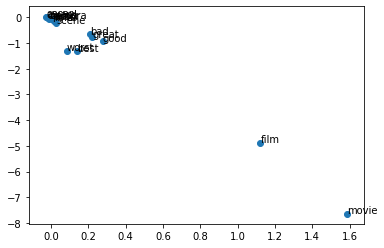

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(M5dist)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'oscar', 'award']

words = [unk_word(word, vocab_5k) for word in words]

ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

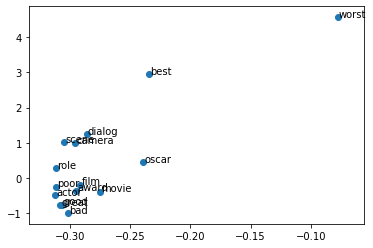

In [29]:
Norm5 = M5dist / np.linalg.norm(M5dist, ord=2, axis=1, keepdims=True)
Norm5[np.isnan(Norm5)] = 0

pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(Norm5)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'oscar', 'award']

words = [unk_word(word, vocab_5k) for word in words]

ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

## Obtenir une représentation: algorithmes couramment utilisés

L'idée, ici, est de définir un ensemble de représentations ${w_{i}}_{i=1}^{V}$, de dimension prédéfinie $d$ (ici, on travaillera avec $d = 300$), pour tous les mots $i$ du vocabulaire $V$ - puis **d'entraîner** ces représentations pour qu'elles correspondent à ce que l'on souhaite. 

### Glove

L'objectif défini par Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) est d'apprendre des vecteurs $w_{i}$ et $w_{k}$ de façon à ce que leur produit scalaire correspondent au logarithme de leur **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


Dans l'article, l'obtention de cet objectif est minutieusement justifié par un raisonnement sur les opérations que l'on veut effectuer avec ces vecteurs et les propriétés qu'ils devraient avoir - notamment, une symétrie entre les lignes et les colonnes (voir l'article pour plus de détails).  
L'objectif final obtenu est le suivant, où $M$ est la matrice de co-occurences:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Ici, $f$ est une fonction de *mise à l'échelle* qui permet de diminuer l'importance des comptes de co-occurences les plus fréquents: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


En général, on choisit $\alpha=0.75$ et $x_{\max} = 100$, même si ces paramètres peuvent nécessiter un changement selon les données.

Le code suivant utilise l'API de gensim pour récupérer des représentations pré-entrainées (Il est normal que le chargement soit long).

In [30]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

On peut extraire la matrice des embeddings ainsi, et vérifier sa taille:

In [31]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


On voit donc qu'il y a $400.000$ mots représentés, et que les embeddings sont de dimension $300$. On définit une fonction qui nous renvoie, à partir du modèle chargé, le vocabulaire et la matrice des embeddings suivant les structures que l'on a utilisé auparavant. On ajoute, ici encore, un mot inconnu ```'UNK'``` au cas où se trouve dans nos données des mots qui ne font pas parti des $400.000$ mots représentés ici. 

In [32]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index2word)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [33]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

Afin de comparer 'à jeu égal' les représentations chargées ici et celles que l'on a produite, il faudrait utiliser le même vocabulaire. Dans ce but, je réutilise le code qui suit pour créer un vocabulaire de $5000$ mots à partir des données exactement comme hier, et j'ajoute à la fin une fonction qui renvoie la matrices des représentations chargées avec Glove pour ces $5000$ mots seulement, dans le bon ordre. 

In [34]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [35]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)

Cette fonction prend donc en entrée le modèle chargé à l'aide de l'API Gensim, ainsi qu'un vocabulaire que nous avons créé nous même, et renvoie la matrice d'embeddings tiré du modèle chargé, pour les mots notre vocabulaire et dans le bon ordre.
Remarque: les mots inconnus sont représentés par le vecteur nul:

In [36]:
print(GloveEmbeddings.shape)
GloveEmbeddings[vocab_5k['UNK']]

(5000, 300)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
print_neighbors(euclidean, vocab_5k, GloveEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, GloveEmbeddings, 'good')

Plus proches voisins de good selon la distance 'euclidean': 
[['better', 'well', 'always', 'really', 'sure', 'way', 'but', 'excellent', 'certainly']]
Plus proches voisins de good selon la distance 'cosine': 
[['better', 'really', 'always', 'you', 'well', 'excellent', 'very', 'things', 'think']]


## Application à l'analyse de sentiments

On va maintenant utiliser ces représentations pour l'analyse de sentiments. 
Le modèle de base, comme hier, sera construit en deux étapes:
- Une fonction permettant d'obtenir des représentations vectorielles des critiques, à partir des textes, du vocabulaire, et des représentations vectorielles des mots. Une telle fonction (à compléter ci-dessous) va associer à chaque mot d'une critique son embeddings, et créer la représentation pour l'ensemble de la phrase en sommant ces embeddings.
- Un classifieur qui prendra ces représentations en entrée et réalisera une prédiction. Pour le réaliser, on pourra utiliser d'abord la régression logistique ```LogisticRegression``` de ```scikit-learn```  

In [38]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
        
    # Pour chaque texte 'text' du corpus 'texts', on considère l'embedding de chaque mot 'word' puis on applique
    # la fonction 'np_func' sur cette liste d'embeddings, ce qui donne la représentation du texte courant.
    
    representations = np.zeros((len(texts), embeddings.shape[1]))
    for k, text in enumerate(texts):
        text_embedding = []
        for word in clean_and_tokenize(text):
            text_embedding.append(embeddings[vocabulary[unk_word(word, vocabulary)]])
        representations[k]= np_func(text_embedding, axis=0)
    return representations

In [39]:
## Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Exemple avec les embeddings obtenus via Gl0ve
rep = sentence_representations(corpus, vocab_5k, GloveEmbeddings)
clf = LogisticRegression(solver='lbfgs',max_iter=100000).fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification Logistic Regression: %s (std %s)' % (round(np.mean(scores), 4), round(np.std(scores), 4)))

0.8384
Score de classification Logistic Regression: 0.832 (std 0.0038)


In [40]:
## SVM

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Exemple avec les embeddings obtenus via Glove
rep = sentence_representations(corpus, vocab_5k, GloveEmbeddings)
# clf = LinearSVC(max_iter=25000).fit(rep[::2], y[::2])
clf = LinearSVC(max_iter=100000).fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification SVM: %s (std %s)' % (round(np.mean(scores), 4), round(np.std(scores), 4)))

/home/pierre/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.81608


/home/pierre/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/pierre/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/pierre/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/pierre/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score de classification SVM: 0.8094 (std 0.0288)


/home/pierre/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Vous pouvez maintenant comparer l'ensemble des méthodes, et notamment répondre aux questions suivantes:
- Pourquoi peut-on s'attendre à ce que les résultats obtenus avec les embeddings extraits des représentations pré-apprises avec Gl0ve soient bien meilleurs que les autres ? Quel serait le moyen de comparer de manière 'juste' Gl0ve avec les autres méthodes d'apprentissage de représentations ?
- Quelle matrice permet d'obtenir les meilleures représentations via SVD ? (Co-occurences, Tf-Idf, PPMI ..)

### Réponses

On obtient les résultats suivants avec Gl0ve sur le corpus `texts` :

|      Classifieur      | Score de classification croisée |
|:---------------------:|:-------------------------------:|
| Régression Logistique |       0.832 (std 0.004)         |
| SVM (`max_iter=25000`)|       0.7918 (std 0.0658)       |
|SVM (`max_iter=100000`)|       0.8094 (std 0.0288)       |

- On constate donc effectivement que les résultats obtenus avec les _embeddings_ extraits des représentations pré-apprises avec Gl0ve sont bien meilleures que les résultats de la première partie. 
- On remarque par ailleurs que Gl0ve considère un vocabulaire de $400000$ mots avec une taille d'_embedding_ de $300$. Une façon plus « juste » de procéder pourrait consister à considérer une taille d'_embedding_ égale pour les autres méthodes de représentations, soit en la définissant de taille $300$, soit en réduisant celle de Gl0ve. Une telle façon de procéder permettrait de considérer des représentations de mots dans des espaces de même dimension et donc de comparer la qualité de l'essence même de ces _embeddings_.
- On note énfin que les résultats obtenus pour la dernière partie considèrent le corpus `texts` et non plus `texts_reduced`, qui correspond à une fraction de $\frac{1}{k} = 10 \%$ (pour `k=10`) de l'ensemble de `texts`. Ainsi, dans la première partie, le jeu de données était bien moins complet. En utilisant Gl0ve avec le corpus réduit `texts_reduced`, les résultats obtenus seraient moins bons qu'ici.
- La matrice permettant d'obtenir la meilleure représentationvia SVD semble être la PPMI. La matrice de co-occurences dont la dimension a été réduite présente également des résultats intéressants. D'une façon générale, les résultats obtenus avec TF-IDF sont moins convaincants.